# Heart disease

U ovoj bilježnici promotrit ću i primijeniti pčelinje algortime za odabir podskupa značajki na skupu podataka koji je vezan za srčane bolesnike u bolnici u Clevelandu. Skup podataka se može skinuti na [1]

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the dataset
dataset = pd.read_csv('processed.cleveland.data', header=None, delimiter=',')
dataset[11] = pd.to_numeric(dataset[11], errors='coerce') 
dataset[12] = pd.to_numeric(dataset[12], errors='coerce') 
X = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

Skup podataka ima 14 značajki od kojih zadnja opisuje odgovarajuću klasu kojoj pacijent pripada, a promatrano je stanje ukupno 303 pacijenta. Dodatni detalji o značajkama se mogu pronaći također na [1] pa tako i informacije koje su značajke kategoričke.

In [3]:
nominal = [1,2,5,6,8,10,11,12]
continious = [0,3,4,7,9]

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [5]:
#types of elements in column in dataframe
dataset.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13      int64
dtype: object

Svi stupci su tipa realni broj, nema nekih neprimjerenih niti "čudnih" tipova pa da moramo to sređivati i prilagođavati.<br>
U nastavku provjeravam ima li nekih podataka koji nedostaju (eng. *missing values*).

In [6]:
#print number of missing values
np.isnan(X).sum()

6

In [7]:
np.isnan(y).sum()

0

Postoji šest polja u *dataset*-u u kojima nedostaje vrijednost, a budući da su sva polja tipa realni broj, problem ćemo riješiti tako da sva polja koja su prazna ispunimo za srednjom vrijednosti stupca. Tako je problem riješen i u članku [2]

In [8]:
# Taking care of missing data
# Updated Imputer
from sklearn.impute import SimpleImputer
missingvalues = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = 0)
missingvalues = missingvalues.fit(X)
X=missingvalues.transform(X)

In [9]:
#print number of missing values (test)
np.isnan(X).sum()

0

Promotrimo sad je li skup podataka balansiran, tj. imamo li podjednak broj pacijenata u svakoj klasi.

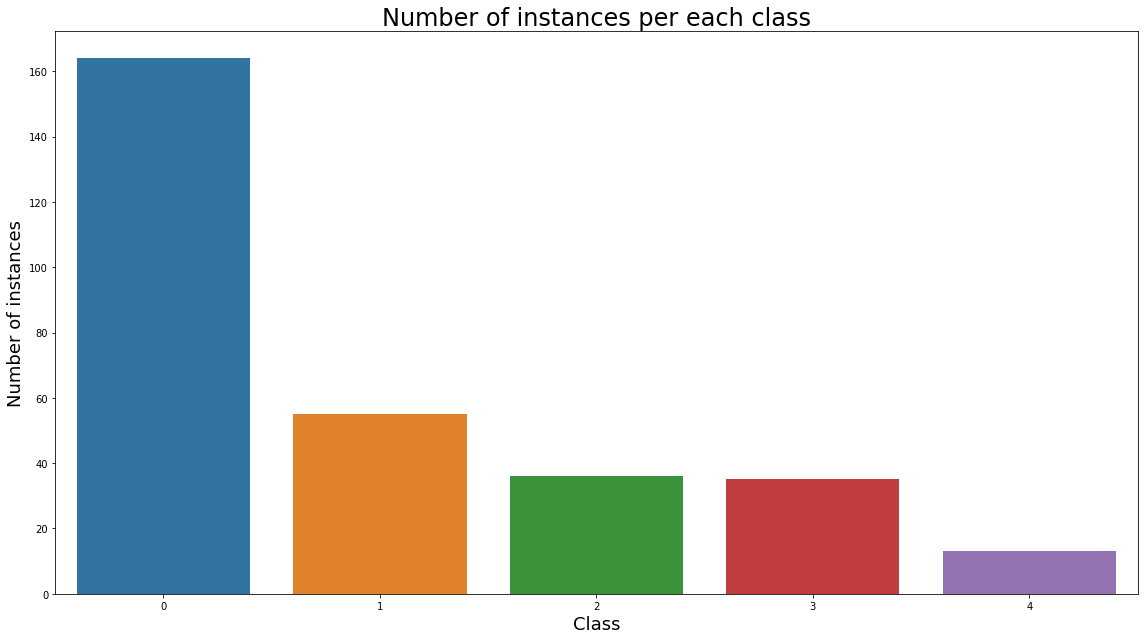

In [10]:
#Is dataset balanced?
column = dataset.shape[1]-1
array_num_instances = dataset[column].value_counts()

#Bar plot
plt.subplots(figsize=(16, 9))

sns.barplot(x=array_num_instances.index, y=array_num_instances)

plt.title('Number of instances per each class', fontsize=24)
plt.xlabel('Class', fontsize=18)
plt.ylabel('Number of instances', fontsize=18)

plt.tight_layout()

Iz gornjeg grafa je očito da skup nije balansiran. Najviše pacijenata spada u klasu 0, tj. najviše ih ima zdravih. Zatim, dosta pacijenata pripada klasi lakših bolesnika, a onda sve manje pacijenata pripada klasama težih srčanih bolesnika. <br>
Skup bi bio balansiraniji kad bi ovaj problem pretvorili u problem binarne klasifikacije, tj. kad bi imali samo klasu pacijenata koji nisu srčani bolesnici i pacijenata koji to jesu. Ipak, da pčelinji algoritam isprobamo na kompliciranijem skupu podataka, ostavljamo ga u ovakvom obliku. <br>
Razlog zašto uopće promatramo je li skup balansiran će bit pojašnjen kasnije.

Sada ćemo proanalizirati postoje li neki podaci u skupu koji jako odskaču od ostalih (eng. *outliers*). U tu svrhu koristimo metodu *percentile*. Podatke podijelimo u gornji i donji kvartil te pomoću tog računamo donju i gornju granicu. Svi podaci koji se nađu ispod/iznad te granice su kandidati za *outliere*.

In [11]:
from numpy import percentile
# calculate interquartile range
for i in range(X.shape[1]):
    q25, q75 = percentile(X[:,i], 25), percentile(X[:,i], 75)
    iqr = q75 - q25
    print(str(i)+': Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in X[:,i] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    print(outliers)

0: Percentiles: 25th=48.000, 75th=61.000, IQR=13.000
Identified outliers: 0
[]
1: Percentiles: 25th=0.000, 75th=1.000, IQR=1.000
Identified outliers: 0
[]
2: Percentiles: 25th=3.000, 75th=4.000, IQR=1.000
Identified outliers: 23
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
3: Percentiles: 25th=120.000, 75th=140.000, IQR=20.000
Identified outliers: 9
[172.0, 180.0, 200.0, 174.0, 178.0, 192.0, 180.0, 178.0, 180.0]
4: Percentiles: 25th=211.000, 75th=275.000, IQR=64.000
Identified outliers: 5
[417.0, 407.0, 564.0, 394.0, 409.0]
5: Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 45
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
6: Percentiles: 25th=0.000, 75th=2.000, IQR=2.000
Identified outliers: 0
[]
7: Percentiles: 25th=13

Druga po redu varijabla je kategorička varijabla i ima previše podataka s istom vrijednosti da bi sve te podatke stavili u kategoriju *outliera*. Isto vrijedi i za petu te jedanaestu varijablu. <br>
Što se tiče neprekidnih varijabli, da bi dobili bolji uvid što se događa, pomaže nam donji graf. Graf je tzv. *pairplot* iz biblioteke *seaborn* i on grafički prikazuje podatke u dvije dimenzije svh mogućih parova danih atributa.

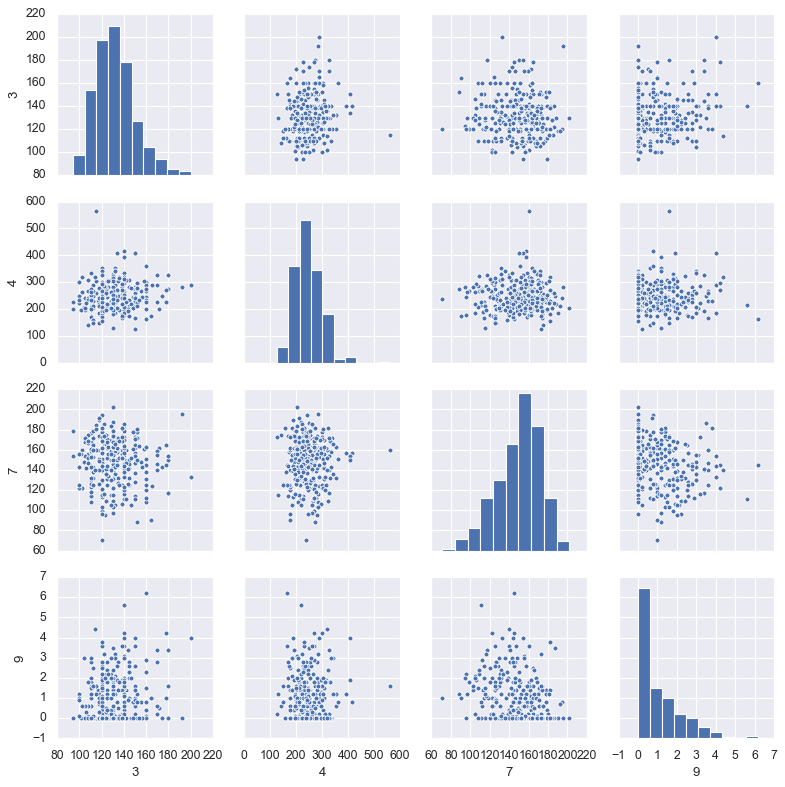

In [12]:
plt.style.use('classic')
X_df = pd.DataFrame(X)
#scatterplot
sns.set()
cols = [3, 4, 7, 9]
sns.pairplot(X_df[cols], height = 2.5)
plt.show();

Treća i sedma varijabla na neki način se "pravilno" raspršuju i ne možemo za neki od podataka utvrditi da je on zaista *outlier*. Kod četrte i devete varijable, malo su sumnjive njihove najveće vrijednosti tj. kod devete njene dvije najveće vrijednosti. Ipak, moramo biti oprezni i ne izbacivati olako podatke iz skupa podataka jer oni mogu jako korisni u treniranju modela klasifikacije. Pogledajmo za te podatke koje indekse imaju u skupu podataka tj. kojem retku pripadaju.

In [13]:
np.where(X[:,4] == 564.0)

(array([152], dtype=int32),)

In [14]:
np.where(X[:,9] == 5.6)

(array([123], dtype=int32),)

In [15]:
np.where(X[:,9] == 6.2)

(array([91], dtype=int32),)

In [16]:
np.where(X[:,7] == 71.0)

(array([245], dtype=int32),)

Očito je da se radi o različitim podacima i trebali bi izbaciti njih 2-3, no isprobat ćemo prvo kakav ćemo rezultat dobiti bez izbacivanja. Ako rezultat ne bude jako dobar, probat ćemo izbaciti neke od ovih potencijalnih *outliera* i ponovo istrenirati model klasifikacije. Zasad je cilj bio izdvojiti i uzeti u obzir najkritičnije podatke. <br>
U nastavku normaliziramo podatke jer koristimo model strojnog učenja koji u obzir uzima duljine između podataka i zato je bitno provesti taj postupak.

In [17]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [18]:
X[0:10]

array([[ 0.94872647,  0.68620244, -2.25177456,  0.75752504, -0.2649003 ,
         2.394438  ,  1.01668424,  0.01719733, -0.69663055,  1.08733806,
         2.27457861, -0.72309499,  0.65581797],
       [ 1.39200191,  0.68620244,  0.87798549,  1.61121989,  0.76041519,
        -0.41763453,  1.01668424, -1.82190531,  1.43548113,  0.39718162,
         0.64911323,  2.50385129, -0.89852225],
       [ 1.39200191,  0.68620244,  0.87798549, -0.6652997 , -0.34228261,
        -0.41763453,  1.01668424, -0.90235399,  1.43548113,  1.34614673,
         0.64911323,  1.42820253,  1.17393137],
       [-1.93256387,  0.68620244, -0.16526786, -0.0961698 ,  0.06397448,
        -0.41763453, -0.99674925,  1.63735918, -0.69663055,  2.12257273,
         2.27457861, -0.72309499, -0.89852225],
       [-1.48928843, -1.4572959 , -1.20852121, -0.0961698 , -0.82592199,
        -0.41763453,  1.01668424,  0.98053681, -0.69663055,  0.31091206,
        -0.97635214, -0.72309499, -0.89852225],
       [ 0.17299446,  0.686202

Budući da je glavni problem koji se promatra u ovom radu, odabir podskupa značajki tj. odabir bitnih značajki pomoću kojih možemo istrenirati dobar klasifikacijski model, malo ćemo pomnije promotriti vezu između nezavisnih značajki i zavisne tj. cilje varijable koja govori kojoj klasi koji pacijent pripada. <br>
Najčešće se takve veze prikazuju grafom zvanim *heatmap*, također iz biblioteke *seaborn*. Jačina boje sugerira, jačinu veze između značajki. Ako promatramo dvije kontinuirane varijable, onda je najbolje računati njihovu korelaciju. Ako promatramo kategoričke varijable, onda više nema smisla gledati korelaciju jer u tom slučaju nije definirana. Tada promatramo tzv. Kramerov V koeficijent asocijacije. Ako pak promatramo jednu kategoričku i jednu kontinuiranu varijablu, onda računamo njihov *correlation ratio*. Više informacija je na [3]

In [19]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [20]:
dict_continious = {}
for i in continious:
    dict_continious[i] = correlation_ratio(y, X[:,i])
mat = pd.DataFrame.from_dict(dict_continious, orient='index')

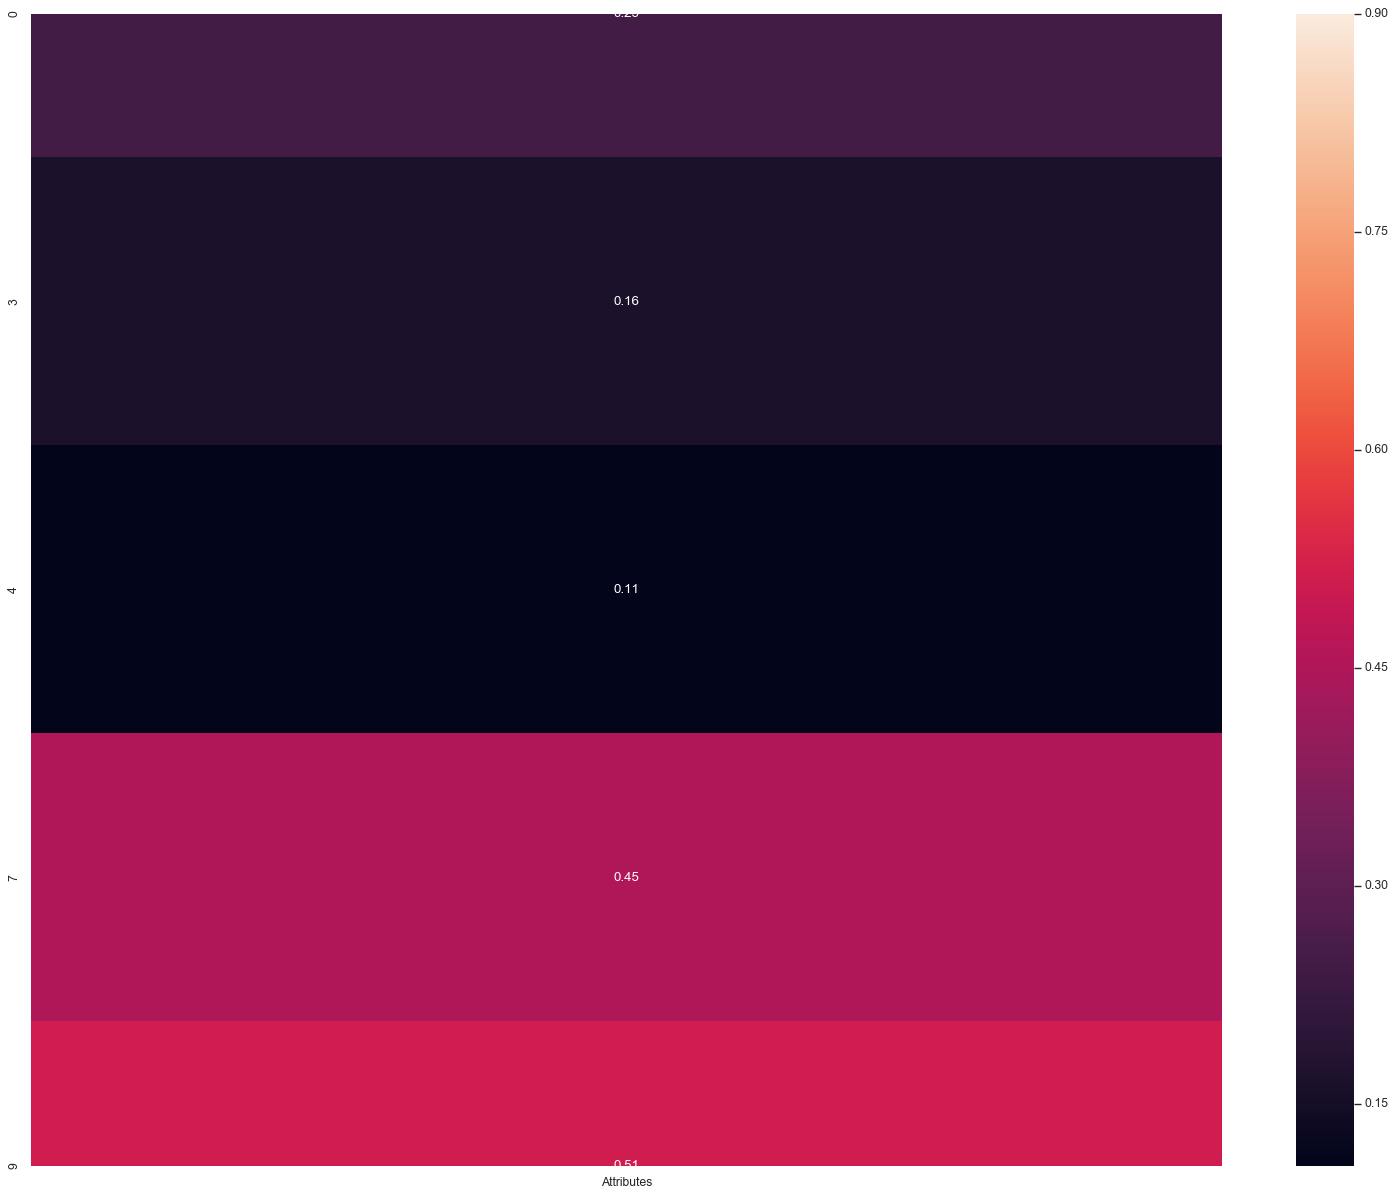

In [21]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(mat, vmax=0.9, annot=True, square=False, yticklabels=mat.index.values, xticklabels=['Attributes']);

In [22]:
import scipy.stats as ss
#Function chi2_contigency cannot work if there are missing values
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [23]:
dict_nominal = {}
for i in nominal:
    dict_nominal[i] = cramers_v(y, X[:,i])
matrix = pd.DataFrame.from_dict(dict_nominal, orient='index')

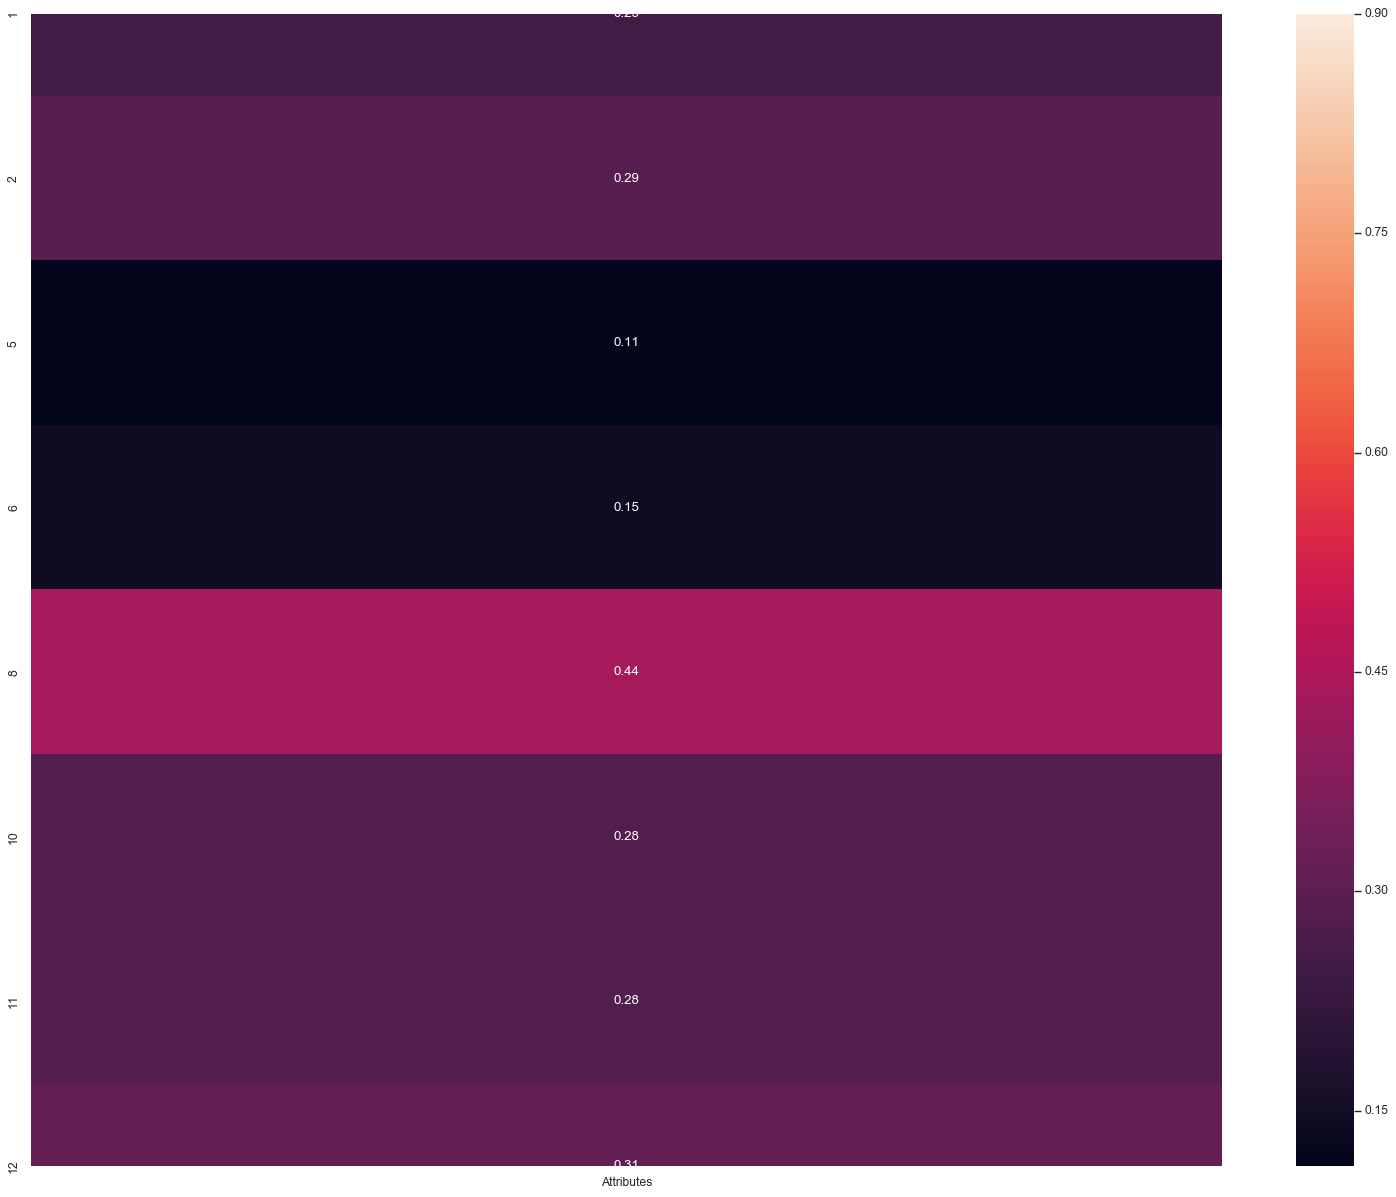

In [24]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(matrix, vmax=0.9, annot=True, square=False, yticklabels=matrix.index.values, xticklabels=['Attributes']);

Iz gornjih grafova, mogu se izdvojiti tri značajke koje su jako povezane i četiri koje su tamno plave boje tj. koje su slabo povezane sa ciljnom varijablom. Po tome bi mogli očekivati da bi naš pčelinji algoritam mogao izbaciti te četiri značajke.

Prije samog algoritma, razdvojimo podatke na one trening i na one testne.

In [25]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

## BABC 

U babc.py su implementirane sve potrebne funckije za algoritam i u bilježnici BABC se nalazi pojašnjenje za svaku funkciju.

In [26]:
import babc

Inicijalizacija potrebnih argumenata za funckije iz babc.py te vrijednosti najboljeg rezultata BEST i pripadnog podskupa značajki prikazanog kao niz nula i jedinica BEST_BEE. Ta varijabla je nazvana BEST_BEE jer je upravo ta pčela tj. to rješenje optimalno u kontekstu pčelinjeg algoritma.

In [27]:
columns_number = X.shape[1]
number_employed_bees = 12
number_onlooker_bees = 12
max_iterations_number = 200
limit = 10
BEST = 0
BEST_BEE = np.zeros(columns_number)

Ranije smo spomenuli balansiranost skupa. Ako skup nije balansiran i ako za mjeru evaluacije klasifikacijskog modela koristimo *accuracy*, može se dogoditi *accuracy paradox* tj. da dobijemo lažnu jako visoku točnost modela jer velik broj podataka pripada jednoj klasi. Više o tome na [4] Postoji dosta načina kako se nositi sa tim problemom, no za naše potrebe koristit ćemo jedan od najjednostavnijih. Koristit ćemo drukčiju evaluacijsku metriku i to jednu od najjednistavnijih koja se dobro nosi sa nebalansiranim podacima, a to je *balanced accuracy*. Više o tom piše u bilježnici BABC.

Na empirijski način, nakon više pokretanja algortima, utvrdila sam da postoji vrijednost rezultata koja se najčešće izbaci kao konačan rezultat i dovoljno je oko tri pokretanja da dobijemo upravo taj rezultat. Zato donju petlju vrtimo tri puta.

Prvo kao klasifikacijski model isprobavamo *K nearest neighbors* i također na empirijski način je utvrđeno da su najbolji rezultati dosad postignuti ako se promatra 5 najbližih susjeda, zato kao argument šaljemo broj 5.

In [28]:
for i in range(3):
    employed_matrix = np.zeros((number_employed_bees,columns_number))
    limit_array = np.zeros(number_employed_bees)
    accuracies = np.zeros(number_employed_bees)
    best = 0
    best_bee = np.zeros(columns_number)
    
    babc.init(number_employed_bees, columns_number, employed_matrix)
    
    babc.init_accuracies_and_best(number_employed_bees, accuracies, X_train, X_test, y_train, y_test, 'KNN', 5, best, best_bee, 
                             employed_matrix, columns_number)
    
    RESULT = babc.iterations(max_iterations_number, limit_array, limit, employed_matrix, number_employed_bees, columns_number, 'KNN', 5, 
                accuracies, number_onlooker_bees, X_train, X_test, y_train, y_test, best, best_bee)
    if (RESULT[0] > BEST):
        BEST = RESULT[0]
        BEST_BEE = RESULT[1]
        
    print(BEST)
    print(BEST_BEE)

0.5996503496503497
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
0.636013986013986
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
0.636013986013986
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]


Ispišimo i *confusion matrix* najbolje dobivenog rezultata.

In [29]:
from sklearn.metrics import confusion_matrix
#best_bee = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0])
k=0
for j in range(0,len(BEST_BEE)):
    if BEST_BEE[j]==1:
        k+=1
X_train_features = np.zeros((X_train.shape[0], k))
X_test_features = np.zeros((X_test.shape[0], k))
        
k=0
for j in range(0,len(BEST_BEE)):
    if BEST_BEE[j]==1:
        X_train_features[:,k]=X_train[:,j]
        X_test_features[:,k]=X_test[:,j]
        k+=1
        
confusion_matrix(y_test, babc.KNN_Classifier(X_train_features, X_test_features, y_train, y_test, 5))

array([[23,  2,  1,  0,  0],
       [ 3,  6,  1,  1,  0],
       [ 2,  0,  2,  0,  0],
       [ 1,  2,  0,  1,  0],
       [ 0,  0,  0,  0,  1]], dtype=int64)

Ako koristimo samo točnost *accuracy*, dobiju se rezultati između 0.85 i 0.9, što je izvrsno, ali se po matrici vidi da situacija nije baš tako dobra i tu vidimo da *balanced accuracy* puno realnije opisuje dobrotu rezultata.

U nastavku ponavljamo isti postupak samo isprobavamo *Random Forest* klasifikaciju sa 10 estimatora.

In [30]:
columns_number = X.shape[1]
number_employed_bees = 12
number_onlooker_bees = 12
max_iterations_number = 50
limit = 10
BEST = 0
BEST_BEE = np.zeros(columns_number)

In [31]:
for i in range(3):
    employed_matrix = np.zeros((number_employed_bees,columns_number))
    limit_array = np.zeros(number_employed_bees)
    accuracies = np.zeros(number_employed_bees)
    best = 0
    best_bee = np.zeros(columns_number)
    
    babc.init(number_employed_bees, columns_number, employed_matrix)
    
    babc.init_accuracies_and_best(number_employed_bees, accuracies, X_train, X_test, y_train, y_test, 'RF', 10, best, best_bee, 
                             employed_matrix, columns_number)
    
    RESULT = babc.iterations(max_iterations_number, limit_array, limit, employed_matrix, number_employed_bees, columns_number, 'RF', 10, 
                accuracies, number_onlooker_bees, X_train, X_test, y_train, y_test, best, best_bee)
    if (RESULT[0] > BEST):
        BEST = RESULT[0]
        BEST_BEE = RESULT[1]
        
    print(BEST)
    print(BEST_BEE)

0.6391608391608392
[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.6555944055944056
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
0.6632867132867133
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]


In [32]:
k=0
for j in range(0,len(BEST_BEE)):
    if BEST_BEE[j]==1:
        k+=1
X_train_features = np.zeros((X_train.shape[0], k))
X_test_features = np.zeros((X_test.shape[0], k))
        
k=0
for j in range(0,len(BEST_BEE)):
    if BEST_BEE[j]==1:
        X_train_features[:,k]=X_train[:,j]
        X_test_features[:,k]=X_test[:,j]
        k+=1
        
confusion_matrix(y_test, babc.KNN_Classifier(X_train_features, X_test_features, y_train, y_test, 5))

array([[21,  2,  2,  1,  0],
       [ 8,  2,  1,  0,  0],
       [ 1,  1,  2,  0,  0],
       [ 1,  3,  0,  0,  0],
       [ 0,  1,  0,  0,  0]], dtype=int64)

Dobijemo nešto bolji rezultat koristeći *Random Forest* klasifikaciju.

Pokušajmo sada izbaciti neki od potencijalnih *outliera* i provjerimo hoćemo li dobiti bolji rezultat. Izbacujemo onaj koji ima maksimalnu vrijednost u četvrtoj varijabli jer najviše odudara od ostalih podataka, dok oni u devetoj varijabli nisu tako upečatljivi.

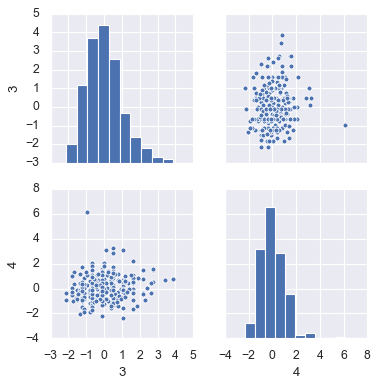

In [33]:
plt.style.use('classic')
X_df = pd.DataFrame(X)
#scatterplot
sns.set()
cols = [3, 4]
sns.pairplot(X_df[cols], height = 2.5)
plt.show();

In [34]:
y = np.delete(y, (np.where(X[:,4] == X[:,4].max())))
X = np.delete(X, (np.where(X[:,4] == X[:,4].max())), axis=0)

Uvjerimo se po grafu jesmo li stvarno uspjeli izbaciti podatak.

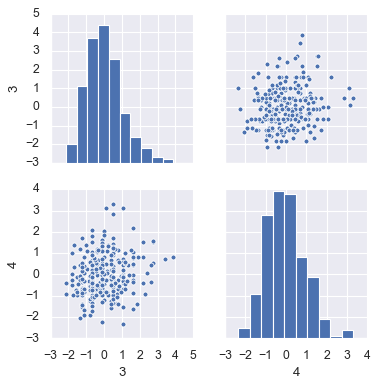

In [35]:
plt.style.use('classic')
X_df = pd.DataFrame(X)
#scatterplot
sns.set()
cols = [3, 4]
sns.pairplot(X_df[cols], height = 2.5)
plt.show();

In [36]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [37]:
columns_number = X.shape[1]
number_employed_bees = 12
number_onlooker_bees = 12
max_iterations_number = 50
limit = 10
BEST = 0
BEST_BEE = np.zeros(columns_number)

In [38]:
for i in range(3):
    employed_matrix = np.zeros((number_employed_bees,columns_number))
    limit_array = np.zeros(number_employed_bees)
    accuracies = np.zeros(number_employed_bees)
    best = 0
    best_bee = np.zeros(columns_number)
    
    babc.init(number_employed_bees, columns_number, employed_matrix)
    
    babc.init_accuracies_and_best(number_employed_bees, accuracies, X_train, X_test, y_train, y_test, 'RF', 10, best, best_bee, 
                             employed_matrix, columns_number)
    
    RESULT = babc.iterations(max_iterations_number, limit_array, limit, employed_matrix, number_employed_bees, columns_number, 'RF', 10, 
                accuracies, number_onlooker_bees, X_train, X_test, y_train, y_test, best, best_bee)
    if (RESULT[0] > BEST):
        BEST = RESULT[0]
        BEST_BEE = RESULT[1]
        
    print(BEST)
    print(BEST_BEE)

0.6555944055944056
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
0.6555944055944056
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
0.6555944055944056
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]


Ne dobijemo bolji rezultat nakon izbacivanja...

Kako bi usporedili "naš" pčelinji algoritam za *feature selection*, provjerit ćemo kakav rezultat dobijemo kad koristimo jedan od najčešće korištenih algoritama u tu svrhu *principal component analysis*. Promotrit ćemo onoliko rezultata koliko ima nezavisnih varijabli. Krećemo od rezultata kad se klasificira uz pomoć samo jedne, po PCA kriterijima, najvažnije značajke, zatim rezultat koji se dobije ako koristimo dvije najvažnije značajke i tako dalje. Zadnji je rezultat kad koristimo sve nezavisne varijable.

In [39]:
from sklearn.metrics import balanced_accuracy_score
def principal_component_analysis(X_train, X_test, columns_number, y_train, y_test, algorithm, n):
    for i in range(1,columns_number+1):

        X_train_temp = np.copy(X_train)
        X_test_temp = np.copy(X_test)  

        # Applying PCA
        from sklearn.decomposition import PCA
        pca = PCA(n_components = i)
        X_train_temp = pca.fit_transform(X_train_temp)
        X_test_temp = pca.transform(X_test_temp)
        explained_variance = pca.explained_variance_ratio_
        if(algorithm == 'KNN'):
            score = balanced_accuracy_score(y_test, babc.KNN_Classifier(X_train_temp, X_test_temp, y_train, y_test, n))
        elif(algorithm == 'RF'):
            score = balanced_accuracy_score(y_test, babc.RF_Classifier(X_train_temp, X_test_temp, y_train, y_test, n))
        elif(algorithm == 'NB'):
            score = balanced_accuracy_score(y_test, babc.NB_Classifier(X_train_temp, X_test_temp, y_train, y_test))
        else:
            raise ValueError('Key word is not recognized.')
        
        print(score)

    print('Explained variance: ')
    print(explained_variance)

In [40]:
principal_component_analysis(X_train, X_test, columns_number, y_train, y_test, 'RF', 10)

0.3325174825174825
0.33916083916083917
0.29790209790209793
0.3073426573426573
0.270979020979021
0.35734265734265735
0.38916083916083916
0.23146853146853147
0.37377622377622377
0.33916083916083917
0.2692307692307693
0.33146853146853145
0.3632867132867133
Explained variance: 
[0.23672593 0.12747943 0.09878653 0.08657739 0.07485658 0.06711189
 0.06403944 0.05942577 0.0513645  0.04037922 0.03300729 0.03185582
 0.0283902 ]


In [41]:
principal_component_analysis(X_train, X_test, columns_number, y_train, y_test, 'KNN', 5)

0.3038461538461538
0.29685314685314684
0.23916083916083916
0.23916083916083916
0.27377622377622374
0.3132867132867133
0.3527972027972028
0.33916083916083917
0.5237762237762238
0.34195804195804197
0.34195804195804197
0.3996503496503497
0.42832167832167833
Explained variance: 
[0.23672593 0.12747943 0.09878653 0.08657739 0.07485658 0.06711189
 0.06403944 0.05942577 0.0513645  0.04037922 0.03300729 0.03185582
 0.0283902 ]


Po dobivenim rezultatima, možemo zaključiti da pčelinji algoritam pronađe značajke s kojima se postiže bolja točnost klasifikacije nego što se postiže s PCA algoritmom.

# Literatura

[1] [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) <br>

[2] [B. Subanya, R. R. Rajalaxmi, A Novel Feature Selection Algorithm for Heart Disease
Classification, International Journal of Computational Intelligence and Informatics,
Vol. 4, No. 2, 2014.](https://www.periyaruniversity.ac.in/ijcii/issue/Vol4No2September2014/IJCII-4-2-144.pdf) <br>

[3] [The Search for Categorical Correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) <br>

[4] [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)